# 2. FERPlus Soft_Attention 분류

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image

from keras.models import Model
from keras.layers import Dense, Embedding, Activation, LSTM, CuDNNGRU, CuDNNLSTM
from keras.layers import GlobalMaxPool2D, MaxPooling2D
from keras.layers import Bidirectional, Input, Add, multiply, Permute, Reshape

Using TensorFlow backend.


## 2.1. 학습에 사용될 하이퍼 패러미터 선언 및 Random Seed 설정

In [2]:
np.random.seed(201)

In [3]:
FERPLUS_DIR = "datasets/ferPlus/prep/"
INPUT_TRAIN_DATA = 'ferPlus_X.npy'
LABEL_TRAIN_DATA = 'ferPlus_y.npy'

TEST_SPLIT = 0.2
RND_SEED = 0

In [4]:
input_data = np.load(open(FERPLUS_DIR + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(FERPLUS_DIR + LABEL_TRAIN_DATA, 'rb'))

In [5]:
input_shape = input_data[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (48, 48, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(input_data,
                                                    label_data,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RND_SEED)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=TEST_SPLIT,
                                                  random_state=RND_SEED)

In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(8784, 48, 48, 1)
(2196, 48, 48, 1)
(2746, 48, 48, 1)


## 2.2 인코더 모델 정의

In [9]:
# Encoder
encoder_base = VGG19(weights=None, include_top=False, input_shape=(48, 48, 1), classes=2)
encoder_outs = encoder_base.layers[-1].output
encoder_outs = Reshape((1, 512))(encoder_outs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## 2.3 디코더 모델 정의

In [10]:
TIME_STEPS = 96
INPUT_DIM  = 512

In [11]:
# Attention Block
def attention_block(inputs):
    input_dim = int(inputs.shape[-1])
    a = Permute((2, 1))(inputs) # same transpose
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul= multiply([inputs, a_probs])
    
    return output_attention_mul

In [12]:
# Decoder
inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
attention_mul = attention_block(encoder_outs)
attention_mul = CuDNNLSTM(2, return_sequences=False)(attention_mul)    
output = Dense(2, activation='softmax')(attention_mul)

In [13]:
model = Model(inputs=encoder_base.input, outputs=output)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 48, 48, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 48, 48, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 24, 24, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

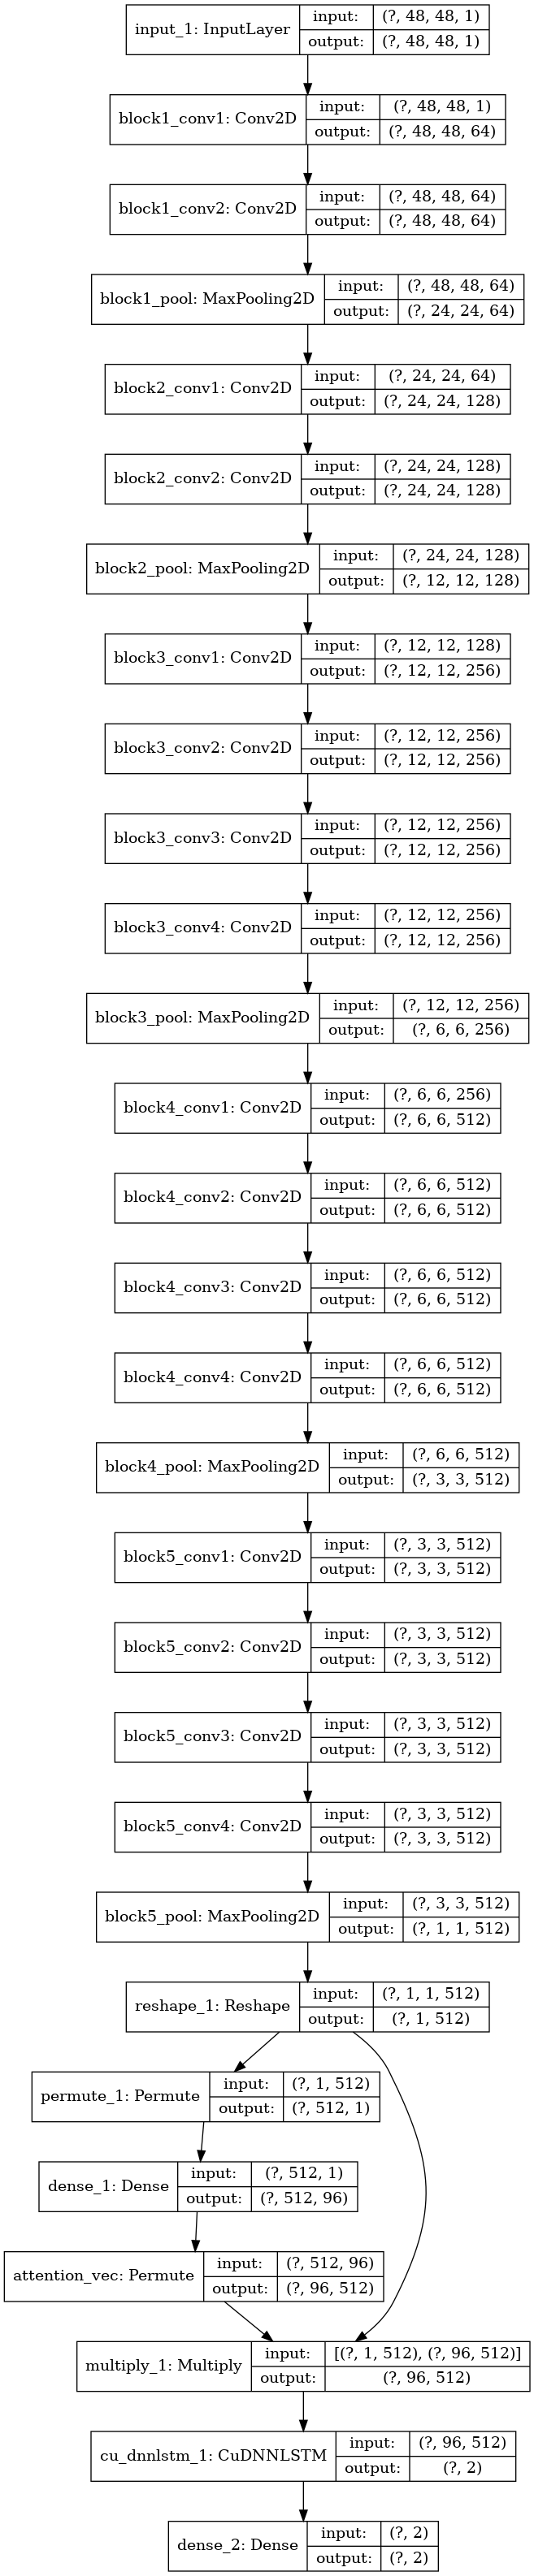

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
MODEL_PATH = 'weights.h5f'

In [18]:
check_point = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', verbose=1, save_best_only=True)

## 2.4 모델 훈련

In [19]:
batch_size = 32
epochs = 100

In [20]:
# Training
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                    validation_data = (x_val, y_val), callbacks=[check_point])


Train on 8784 samples, validate on 2196 samples
Epoch 1/100
8784/8784 [==============================] - 11s 1ms/step - loss: 0.6338 - accuracy: 0.6766 - val_loss: 0.6143 - val_accuracy: 0.6972

Epoch 00001: val_loss improved from inf to 0.61430, saving model to weights.h5f
Epoch 2/100
8784/8784 [==============================] - 9s 986us/step - loss: 0.6276 - accuracy: 0.6791 - val_loss: 0.6136 - val_accuracy: 0.6972

Epoch 00002: val_loss improved from 0.61430 to 0.61355, saving model to weights.h5f
Epoch 3/100
8784/8784 [==============================] - 9s 981us/step - loss: 0.6279 - accuracy: 0.6791 - val_loss: 0.6138 - val_accuracy: 0.6972

Epoch 00003: val_loss did not improve from 0.61355
Epoch 4/100
8784/8784 [==============================] - 9s 984us/step - loss: 0.6278 - accuracy: 0.6791 - val_loss: 0.6146 - val_accuracy: 0.6972

Epoch 00004: val_loss did not improve from 0.61355
Epoch 5/100
8784/8784 [==============================] - 9s 976us/step - loss: 0.6279 - accura

8784/8784 [==============================] - 9s 986us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6144 - val_accuracy: 0.6972

Epoch 00040: val_loss did not improve from 0.61324
Epoch 41/100
8784/8784 [==============================] - 9s 979us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6146 - val_accuracy: 0.6972

Epoch 00041: val_loss did not improve from 0.61324
Epoch 42/100
8784/8784 [==============================] - 9s 986us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6144 - val_accuracy: 0.6972

Epoch 00042: val_loss did not improve from 0.61324
Epoch 43/100
8784/8784 [==============================] - 9s 988us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6137 - val_accuracy: 0.6972

Epoch 00043: val_loss did not improve from 0.61324
Epoch 44/100
8784/8784 [==============================] - 9s 984us/step - loss: 0.6278 - accuracy: 0.6791 - val_loss: 0.6136 - val_accuracy: 0.6972

Epoch 00044: val_loss did not improve from 0.61324
Epoch 45/100


8784/8784 [==============================] - 9s 979us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6144 - val_accuracy: 0.6972

Epoch 00081: val_loss did not improve from 0.61324
Epoch 82/100
8784/8784 [==============================] - 9s 983us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6144 - val_accuracy: 0.6972

Epoch 00082: val_loss did not improve from 0.61324
Epoch 83/100
8784/8784 [==============================] - 9s 991us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6136 - val_accuracy: 0.6972

Epoch 00083: val_loss did not improve from 0.61324
Epoch 84/100
8784/8784 [==============================] - 9s 993us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6140 - val_accuracy: 0.6972

Epoch 00084: val_loss did not improve from 0.61324
Epoch 85/100
8784/8784 [==============================] - 9s 980us/step - loss: 0.6277 - accuracy: 0.6791 - val_loss: 0.6141 - val_accuracy: 0.6972

Epoch 00085: val_loss did not improve from 0.61324
Epoch 86/100


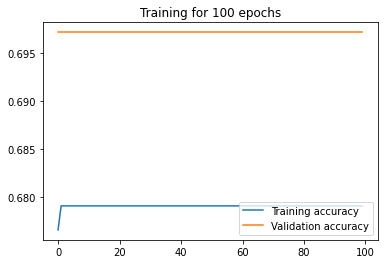

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

검증셋 정확도

In [22]:
model.load_weights(MODEL_PATH)
results = model.evaluate(x_val, y_val)
print('Test accuracy: ', results[1])

2196/2196 [==============================] - 1s 322us/step
Test accuracy:  0.6971766948699951


테스트셋 정확도

In [23]:
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

2746/2746 [==============================] - 1s 395us/step
Test accuracy:  0.6769847273826599
